In [210]:
%matplotlib notebook
import matplotlib.pylab as plt

import numpy as np
import pandas as pd

import numpy as np
import importlib
import integralclient as ic
importlib.reload(ic)
ic.__file__

In [ ]:
from collections import defaultdict
import glob
from astropy.wcs import WCS

import astropy.io.fits as fits
from astropy import units as u
from astropy import constants as const

import importlib
import integralclient as ic
import numpy as np

import hashlib

hashstring = lambda x:hashlib.sha224(x.encode()).hexdigest()[:8]


In [295]:
t0_utc="2020-04-28T14:34:33"
t1_rel_days=-1
t2_rel_days=1.5
source_name="SGR 1935+2154"

In [296]:
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
t=Simbad.query_object(source_name)
source_coord = SkyCoord(t[0]['RA'], t[0]['DEC'], unit=("hourangle", "deg"))
source_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (293.732, 21.89672222)>

In [450]:
import yaml

bursts = yaml.load(open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml"))

#for b in bursts[]

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


# v1 burst selection

TOTAL          24.19  - 24.79

PREBUMP    24.19  - 24.395

BUMP           24.395 - 24.536

POSTBUMP   24.536 - 24.79


PEAK 1     24.431 - 24.435

PEAK 2     24.454 - 24.464

PEAK 3     24.487 - 24.495



In [863]:
v1_intervals={}

for k, t1, d,t2 in [r.split() for r in """TOTAL          24.19  - 24.79
PREBUMP    24.19  - 24.395
BUMP           24.395 - 24.536
POSTBUMP   24.536 - 24.79
PEAK_1     24.431 - 24.435
PEAK_2     24.454 - 24.464
PEAK_3     24.487 - 24.495""".split("\n")]:
    print(k,t1,t2)
    v1_intervals[k] = dict(t1=float(t1), t2=float(t2))


TOTAL 24.19 24.79
PREBUMP 24.19 24.395
BUMP 24.395 24.536
POSTBUMP 24.536 24.79
PEAK_1 24.431 24.435
PEAK_2 24.454 24.464
PEAK_3 24.487 24.495


In [ ]:
def oda_image(t0_geo, dt1, dt2):
    t0_geo_ijd = float(ic.converttime("ANY", t0_geo, "IJD"))
    t0_geo_isot = ic.converttime("ANY", t0_geo, "UTC")
    
    barycorr = ic.get_sc(t0_geo_isot, ra=source_coord.ra.deg, dec=source_coord.dec.deg)['barytime']
    
    print(barycorr)
    
    t0_int_ijd = t0_geo_ijd - barycorr/24./3600.
    
    t1_utc = ic.converttime("IJD", 
                               t0_int_ijd + dt1/24/3600, 
                               "UTC")

    t2_utc = ic.converttime("IJD", 
                            t0_int_ijd + dt2/24/3600, 
                            "UTC")

    scw=ic.converttime("IJD", t0_int_ijd, "SCWID")
    
    r = ddac.query('ii_skyimage', 
                modules=modules,
                assume=[
                   'ddosa.ScWData(input_scwid="{}.000")'.format(scw),
                   'ddosa.ibis_gti(input_usergti=ddosa.gti_user)',
                   'ddosa11.BinEventsImage(use_NoisyDetFlag=0)',
                   'ddosa.UserGTI(use_gti=["{}", "{}"], use_version="{}")'.format(t1_utc,t2_utc, hashstring(t1_utc+t2_utc)),                
               ],
               prompt_delegate=True,
               inject=[cat],
               #callback="http://nourl?sessionid=testsession&jobid=testjob"
            )
    
    return r

for k, v in v1_intervals.items():
    try:
        v['image'] = oda_image("2020-04-28T14:34:00", v['t1'], v['t2'])
    except ddaclient.AnalysisDelegatedException as e:
        print("waiting", e)



In [927]:
MasDetDisDim=3202.0 
PixAngDim = np.arctan(1./MasDetDisDim)*180./np.pi

PixAngDim*60

1.073624815433753

In [916]:
for k, v in v1_intervals.items():
    print(k)
    print(v['image'].skyres)
    d = fits.open(v['image'].skyres)[2].data
    print(d['DETSIG'])
    v['image-detsig'] = float(d['DETSIG'][0])
    v['coord'] = dict(
        ra_fin = d['RA_FIN'][0],
        dec_fin = d['DEC_FIN'][0],
        fin_rd_err_deg = d['FIN_RD_ERR'][0],
        fin_rd_err_arcmin = d['FIN_RD_ERR'][0]*60,
    )
    v['coord']['from_true_position_deg'] = source_coord.separation(
        SkyCoord(v['coord']['ra_fin'], v['coord']['dec_fin'], unit='deg')
    ).deg
    print(v['coord'])

TOTAL
/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/byscw/2222/222200240010.000/ii_skyimage.v2/995e4499/isgri_sky_res.fits.gz
[20.284025]
{'ra_fin': 293.72403, 'dec_fin': 21.896017, 'fin_rd_err_deg': 0.023774546, 'fin_rd_err_arcmin': 1.4264727383852005, 'from_true_position_deg': 0.007429010515442668}
PREBUMP
/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/byscw/2222/222200240010.000/ii_skyimage.v2/930057a4/isgri_sky_res.fits.gz
[5.289355]
{'ra_fin': 293.72284, 'dec_fin': 21.87206, 'fin_rd_err_deg': 0.07835142, 'fin_rd_err_arcmin': 4.701085388660431, 'from_true_position_deg': 0.02608535195229097}
BUMP
/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/byscw/2222/222200240010.000/ii_skyimage.v2/78c171c1/isgri_sky_res.fits.gz
[17.179625]
{'ra_fin': 293.7212, 'dec_fin': 21.901697, 'fin_rd_err_deg': 0.027382659, 'fin_rd_err_arcmin': 1.6429595276713371, 'from_true_position_deg': 0.01119482

In [919]:
yaml.dump(
    simplify.simplify(
        {k:{a:b for a,b in v.items() if a not in ["image", "spectrum"]}
            for k,v in v1_intervals.items()}
    ), 
    open('5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-summary.yaml', "w"))

In [536]:
import ddaclient

importlib.reload(ddaclient)

ddac = ddaclient.RemoteDDOSA("http://cdcihn/staging-1.2/ddosa-worker-osa11", 
                      "/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/")

modules = ['git://ddosa',
           'git://findic/icversion', 
           'git://ddosa11/icversion-noisecontrol', 
           'git://gencat',
           'git://ddosa_delegate']


cat = ("SourceCatalog", 
           {
            "autoversion": True, 
            "catalog": [
                {"NAME":"SGR 1935+2154", "RA": 293.73200 , "DEC":  21.89672}
            ]
           }
      )


for burst in bursts:
    rs = {}
    burst['image_results'] = rs
    
    #if '14:34:' not in burst['utc_integral']:
    #    print("skipping", burst['utc_integral'])
    #    continue
    
    for dt_extra in 0,0.1,0.05:
        burst_0_ijd = burst['ijd']
        dt1 = burst['bblocks']['t1_rel_s'] - dt_extra
        dt2 = burst['bblocks']['t2_rel_s'] + dt_extra

        print(dt1,dt2)

        #if burst['snr']<40:   
        #    continue

        burst['image_results'] = rs

        t1_utc = ic.converttime("IJD", 
                               burst_0_ijd + dt1/24/3600, 
                               "UTC")

        t2_utc = ic.converttime("IJD", 
                            burst_0_ijd + dt2/24/3600, 
                            "UTC")

        scw=ic.converttime("IJD", burst_0_ijd, "SCWID")

        try:
            r = ddac.query('ii_skyimage', 
                        modules=modules,
                        assume=[
                           'ddosa.ScWData(input_scwid="{}.000")'.format(scw),
                           'ddosa.ibis_gti(input_usergti=ddosa.gti_user)',
                           'ddosa11.BinEventsImage(use_NoisyDetFlag=0)',
                           'ddosa.UserGTI(use_gti=["{}", "{}"], use_version="{}")'.format(t1_utc,t2_utc, hashstring(t1_utc+t2_utc)),                
                       ],
                       prompt_delegate=True,
                       inject=[cat],
                       #callback="http://nourl?sessionid=testsession&jobid=testjob"
                    )
            rs[(dt1,dt2)] = r

        except Exception as e:
            print("exception", repr(e))
        
    #break




-0.04888310213573277 0.010259999544359744
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590428203562624/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590435048829022/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590433861329075/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:52.115", "2020-04-28T03:47:52.174"], use_version="e5fe8849")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590446622903983/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590433861329075/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:52.015", "2020-04-28T03:47:52.274"], use_version="5be31dad")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'p

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590440835861955/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1590433861329075/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T03:47:52.065", "2020-04-28T03:47:52.224"], use_version="9a287794")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'p

(<ddaclient.DDOSAproduct object at 0x7ff399512da0>, '{"origin": "dda", "relativeCreated": 3.6058425903320312, "process": 73446, "@timestamp": "2020-05-07T08:20:04.627Z", "args": [], "module": "printhook", "funcName": "setup_logstash", "levels": ["callback"], "message": "starting logstash logger", "name": "logstash_logger", "thread": 140345324394304, "created": 1588839604.62721, "threadName": "MainThread", "msecs": 627.2099018096924, "filename": "printhook.py", "levelno": 20, "processName": "MainProcess", "source_host": "efe563e6c3b4", "pathname": "/dev-packages/data-analysis/dataanalysis/printhook.py", "lineno": 82, "main": "/dev-packages/data-analysis/dataanalysis/printhook.py", "@version": 1, "levelname": "INFO"}\n/home/integral/.pyenv/versions/2.7.12/lib/python2.7/site-packages/astropy/config/configuration.py:541: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:13 on None\n  warn(ConfigurationMissingWarning(msg))\n/home/integral/.pyenv/versions/2.7.12

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1742643781471997/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:47.191", "2020-04-28T04:09:47.481"], use_version="90cb8217")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.1742643781471997/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200040010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T04:09:47.241", "2020-04-28T04:09:47.431"], use_version="911a4d3a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2483767183193777/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.451", "2020-04-28T05:56:30.561"], use_version="a90c0888")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2483767183193777/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.351", "2020-04-28T05:56:30.661"], use_version="cd6173f8")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2483767183193777/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T05:56:30.401", "2020-04-28T05:56:30.611"], use_version="0f292027")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2562053841720626/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.819", "2020-04-28T06:07:46.990"], use_version="7f746800")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2562068798360997/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2562053841720626/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.719", "2020-04-28T06:07:47.090"], use_version="82b8fa4b")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'p

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.2562053841720626/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200080010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T06:07:46.769", "2020-04-28T06:07:47.040"], use_version="904f8695")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.3366139923409719/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200120010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T08:03:34.260", "2020-04-28T08:03:34.305"], use_version="cbef6421")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.3366139923409719/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200120010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T08:03:34.160", "2020-04-28T08:03:34.405"], use_version="6cad7d87")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.3366139923409719/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200120010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T08:03:34.210", "2020-04-28T08:03:34.355"], use_version="4980ebc4")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.4112725193954248/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.732", "2020-04-28T09:51:05.109"], use_version="d075dcc3")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.4112725193954248/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.632", "2020-04-28T09:51:05.209"], use_version="76a5f15a")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.4112725193954248/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200150010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T09:51:04.682", "2020-04-28T09:51:05.159"], use_version="6f03a00f")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080248525859133/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.999", "2020-04-28T14:34:24.754"], use_version="72c1fe9b")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080248525859133/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.899", "2020-04-28T14:34:24.854"], use_version="e23c1f16")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080248525859133/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200240010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:23.949", "2020-04-28T14:34:24.804"], use_version="0ca712f2")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7424.3833650857004613/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200550010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-29T09:10:53.571", "2020-04-29T09:10:53.627"], use_version="d6e52c2f")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7424.3833650857004613/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200550010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-29T09:10:53.471", "2020-04-29T09:10:53.727"], use_version="48cbc980")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7424.3833650857004613/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222200550010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-29T09:10:53.521", "2020-04-29T09:10:53.677"], use_version="7923b9f9")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://d

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7428.976648681145889/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222400270010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-03T23:25:13.257", "2020-05-03T23:25:13.408"], use_version="8970f785")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://dd

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7428.976648681145889/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222400270010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-03T23:25:13.157", "2020-05-03T23:25:13.508"], use_version="78360de1")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://dd

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7428.976648681145889/SCWID
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://ddosa_delegate') {}
('assume', 'ddosa.ScWData(input_scwid="222400270010.000"),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsImage(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-05-03T23:25:13.207", "2020-05-03T23:25:13.458"], use_version="664f6628")') {}
('service url:', 'http://cdcihn/staging-1.2/ddosa-worker-osa11') {}
('target:', 'ii_skyimage') {}
('inject:', [('SourceCatalog', {'autoversion': True, 'catalog': [{'NAME': 'SGR 1935+2154', 'RA': 293.732, 'DEC': 21.89672}]})]) {}
('request will be sent to OSA11',) {}
('request to pipeline:', {'url': 'http://cdcihn/staging-1.2/ddosa-worker-osa11/api/v2.0/ii_skyimage', 'params': {'modules': 'git://ddosa,git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://dd

In [537]:

#plt.figure(figsize=(9,7))

#plt.grid()


for burst in bursts:
    rs = burst['image_results']
    if rs=={}: continue
        
    #if '14:34:' in burst['utc_integral']:
     #   break
    
    image_snr_by_dt_scale = {}
    
    print(burst['utc_integral'])
    
    for (dt1,dt2), r in rs.items():
        
        if not hasattr(r,'skyres'):
            print("failed skyres", dt1,dt2)
            continue
            
        skyres = fits.open(r.skyres)[2]
        d=skyres.data
        #m = d['DETSIG']>0
        m = d['NAME'] == 'SGR 1935+2154'
                
        print(dt1,dt2, d['NAME'][m], d['DETSIG'][m])

        if sum(m) != 0:
            image_snr_by_dt_scale[(dt1,dt2)] = d['DETSIG'][m][0]
   
    if False:
        plt.plot(
        np.array(list(image_snr_by_dt_scale.keys())),
        np.array(list(image_snr_by_dt_scale.values())),
        label=burst['utc_integral']
    )
    
    if len(image_snr_by_dt_scale)==0:
        print("does not qualify")
        burst['image_confirmed'] = False
    else:
        burst['image_confirmed'] = True
        burst['image_snr_by_dt_scale']  = image_snr_by_dt_scale
        burst['best_image_time_scale'] = max(image_snr_by_dt_scale.items(), key=lambda x:x[1])

if False:
    plt.xlabel("$\Delta$t: $\pm$ seconds from {}".format(burst_0_utc))
    plt.ylabel("image S/N")
    plt.legend()

    plt.semilogx()

    #!mkdir -pv draft/PAPER_SGR1935_INTEGRAL/fig/diagnostic
    plt.savefig("draft/PAPER_SGR1935_INTEGRAL/fig/diagnostic/SN_vs_timescale_multiburst.pdf")


2020-04-28T03:47:52.164
-0.04888310213573277 0.010259999544359744 ['SGR 1935+2154'] [5.1989546]
-0.14888310213573278 0.11025999954435975 ['SGR 1935+2154'] [5.433797]
2020-04-28T04:09:47.258
0.03285059065092355 0.12299945228733122 ['SGR 1935+2154'] [4.7337427]
-0.06714940934907646 0.22299945228733123 ['SGR 1935+2154'] [3.9765816]
-0.017149409349076453 0.1729994522873312 ['SGR 1935+2154'] [4.297237]
2020-04-28T05:56:30.564
-0.11300992628093809 -0.0027804082492366433 ['SGR 1935+2154'] [7.159565]
-0.2130099262809381 0.09721959175076336 ['SGR 1935+2154'] [6.3318796]
-0.16300992628093808 0.04721959175076336 ['SGR 1935+2154'] [6.6498556]
2020-04-28T06:07:46.961
-0.14197825512383133 0.029225365142337978 ['SGR 1935+2154'] [5.934225]
-0.24197825512383134 0.12922536514233798 ['SGR 1935+2154'] [5.9864283]
-0.19197825512383132 0.07922536514233798 ['SGR 1935+2154'] [6.154187]
2020-04-28T08:03:34.264
-0.003939546877518296 0.040738171082921326 ['SGR 1935+2154'] [2.4832804]
-0.1039395468775183 0.140738

In [895]:
#def evaluate_sumspec(scw, t1_utc, t2_utc, rebinfactor):
def evaluate_sumspec(t0, t1_rel_s, t2_rel_s, rebinfactor=4, scale="integral"):
    
    if scale == "geo":    
        t0_geo_ijd = float(ic.converttime("ANY", t0, "IJD"))
        t0_geo_isot = ic.converttime("ANY", t0, "UTC")

        barycorr = ic.get_sc(t0_geo_isot, ra=source_coord.ra.deg, dec=source_coord.dec.deg)['barytime']    
        print(barycorr)    

        t0_ijd_integral = t0_geo_ijd - barycorr/24./3600.

    
    scw = ic.converttime("ANY", t0_ijd_integral, "SCWID")
    t1_utc = ic.converttime("IJD", t0_ijd_integral + t1_rel_s/24./3600,"UTC")
    t2_utc = ic.converttime("IJD", t0_ijd_integral + t2_rel_s/24./3600,"UTC")
        
    print(scw, t1_utc, t2_utc)
    
    modules = ['git://ddosa',
           'git://findic/icversion', 
           'git://ddosa11/icversion-noisecontrol', 
           'git://gencat',
           'git://useresponse/osa11',
           'git://process_isgri_spectra/osa11',
           'git://ddosa_delegate',
              ]

    
    r = ddac.query('ISGRISpectraSum', 
                        modules=modules,
                        assume=[
                           #'ddosa.GRcat(use_userefcatvar=True, use_useresources=False)',            
                           'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList)',
                           'ddosa.IDScWList(use_scwid_list=["{}.000"])'.format(scw),                           
                           'ddosa.ibis_gti(input_usergti=ddosa.gti_user)',
                           'ddosa11.BinEventsSpectra(use_NoisyDetFlag=0)',
                           'ddosa.UserGTI(use_gti=["{}", "{}"], use_version="{}")'.format(t1_utc,t2_utc, hashstring(t1_utc+t2_utc)),
                           'useresponse.CompressEBins(use_factor={})'.format(rebinfactor),
                       ],
                       prompt_delegate=True,
                       inject=[cat],
                       #callback="http://nourl?sessionid=testsession&jobid=testjob"
                    )
    
    return r

if False:
    for burst in bursts:
        #if '14:34' not in burst['utc_integral']:
        #    continue    

        sr = {}
        burst['specres']=sr

        for rb in 4,8:
            try:
                sr[rb] = evaluate_sumspec(burst['ijd'], burst['bblocks']['t1_rel_s'], burst['bblocks']['t2_rel_s'], rb)
            except:
                pass
else:
    for k, v in v1_intervals.items():
        try:
            v['spectrum'] = evaluate_sumspec("2020-04-28T14:34:00", v['t1'], v['t2'], scale="geo")
        except ddaclient.AnalysisDelegatedException as e:
            print("waiting", e)


url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/IJD
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/UTC
0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080229076778778/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080298521228542/UTC
222200240010 2020-04-28T14:34:23.995 2020-04-28T14:34:24.595
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["2

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/UTC
0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080229076778778/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080252803631083/UTC
222200240010 2020-04-28T14:34:23.995 2020-04-28T14:34:24.200
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["222200240010.000"]),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsSpectra(use_NoisyDetFlag=0),ddosa.UserGTI(

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/UTC
0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080252803631083/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080269123076505/UTC
222200240010 2020-04-28T14:34:24.200 2020-04-28T14:34:24.341
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["222200240010.000"]),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsSpectra(use_NoisyDetFlag=0),ddosa.UserGTI(

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/UTC
0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080269123076505/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080298521228542/UTC
222200240010 2020-04-28T14:34:24.341 2020-04-28T14:34:24.595
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["222200240010.000"]),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsSpectra(use_NoisyDetFlag=0),ddosa.UserGTI(

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/UTC
0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.608025697029916/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080257433259249/UTC
222200240010 2020-04-28T14:34:24.236 2020-04-28T14:34:24.240
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["222200240010.000"]),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsSpectra(use_NoisyDetFlag=0),ddosa.UserGTI(u

url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/2020-04-28T14:34:00/UTC
0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080259632335583/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.608026078974035/UTC
222200240010 2020-04-28T14:34:24.259 2020-04-28T14:34:24.269
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["222200240010.000"]),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsSpectra(use_NoisyDetFlag=0),ddosa.UserGTI(u

0.19477659925574106
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/ANY/7423.6077429308261344/SCWID
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080263451776773/UTC
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/IJD/7423.6080264377706044/UTC
222200240010 2020-04-28T14:34:24.292 2020-04-28T14:34:24.300
('modules', 'git://ddosa,git://findic/icversion,git://ddosa11/icversion-noisecontrol,git://gencat,git://useresponse/osa11,git://process_isgri_spectra/osa11,git://ddosa_delegate') {}
('assume', 'process_isgri_spectra.ScWSpectraList(input_scwlist=ddosa.IDScWList),ddosa.IDScWList(use_scwid_list=["222200240010.000"]),ddosa.ibis_gti(input_usergti=ddosa.gti_user),ddosa11.BinEventsSpectra(use_NoisyDetFlag=0),ddosa.UserGTI(use_gti=["2020-04-28T14:34:24.292", "2020-04-28T14:34:24.300"], use_version="c09350f5"),useresponse.CompressEBins(use_facto

In [896]:
import os, shutil

def patch_zero_bins(inf, outf):
    s = fits.open(inf)
    s[1].data['QUALITY'][s[1].data['STAT_ERR']<=0]=3
    s.writeto(outf, overwrite=True)
    


In [904]:
for k, v in v1_intervals.items():
    sr = v['spectrum']
    
    s = getattr(sr, 'isgri_sum_SGR_1935+2154')
    r = getattr(sr, 'rmf_sum_SGR_1935+2154')
    
    td = f"5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-v1-intervals/{k}/"    
    
    try:
        print(f"to make {td}")
        os.makedirs(td)
    except Exception as e:
        print("?", e)
        
    patch_zero_bins(s, td+"/isgri_sgr.fits.gz")    
    shutil.copyfile(r, td+"/rmf.fits.gz")
        
    r = fits.open(r)
    s = fits.open(s)[1]
    
    burst['hratio'], burst['hratio_err'] = hratio(s, r)
    
    print(burst['hratio'], burst['hratio_err'])
    


to make 5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-v1-intervals/TOTAL/
638.1807098388672 286.09447706079106
454.55655670166016 179.93959252484655
0.7122693458039967 0.3772136941431393
to make 5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-v1-intervals/PREBUMP/
726.4598922729492 326.8333371512727
388.8557186126709 159.5889456111522
0.5352748620381758 0.26799489292706313
to make 5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-v1-intervals/BUMP/
2102.5372314453125 943.0023942838109
1518.148422241211 600.170608881862
0.722055428810464 0.3838731368093671
to make 5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-v1-intervals/POSTBUMP/
695.8506546020508 314.4901115670213
554.8740463256836 221.0957663335619
0.7974039295012374 0.44053557882280614
to make 5eaaeadefc30e100011b844d/PAPER_SGR1935_INTEGRAL/data/spectra/burst1434-v1-intervals/PEAK_1/
14849.15966796875 6767.219702359308
4227.2923583984375 2

In [697]:
for burst in bursts:
    if 'specres' not in burst: continue
    
    sr = burst['specres']
    
    s8 = getattr(sr[8], 'isgri_sum_SGR_1935+2154')
    s4 = getattr(sr[4], 'isgri_sum_SGR_1935+2154')
    r8 = getattr(sr[8], 'rmf_sum_SGR_1935+2154')
    r4 = getattr(sr[4], 'rmf_sum_SGR_1935+2154')
    print(s4)
    
    td = "draft/PAPER_SGR1935_INTEGRAL/data/spectra/burst_{}/".format(burst['utc_integral'].replace(":","-"))
    
    try:
        os.makedirs(td)
    except: pass
    
    patch_zero_bins(s4, td+"/isgri_sgr_r4.fits.gz")
    patch_zero_bins(s8, td+"/isgri_sgr_r8.fits.gz")
    shutil.copyfile(r4, td+"/rmf_r4.fits.gz")
    shutil.copyfile(r8, td+"/rmf_r8.fits.gz")
        
    r = fits.open(r8)
    s = fits.open(s8)[1]
    
    burst['hratio'], burst['hratio_err'] = hratio(s, r)
    
    print(burst['hratio'], burst['hratio_err'])
    


/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/global/ISGRISpectraSum.v5.8.2.extractall/c61961c7/isgri_sum_SGR_1935+2154.fits.gz
4101.15478515625 2926.1437507408964
1842.1468659937382 1396.7836815237565
0.44917760057757833 0.7906127619451656
/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/global/ISGRISpectraSum.v5.8.2.extractall/b80c210c/isgri_sum_SGR_1935+2154.fits.gz
2730.640869140625 1931.3212122793038
1659.5645103007555 997.70967313374
0.6077564168381637 0.796078522619776
/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/global/ISGRISpectraSum.v5.8.2.extractall/2af19930/isgri_sum_SGR_1935+2154.fits.gz
1529.4166870117188 1093.7872136526373
1316.141418337822 596.605766558696
0.8605512346732603 0.8146353480113219
/mnt/sshfs/isdc-in01/unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2/global/ISGRISpectraSum.v5.8.2.extractall/e4c6ab56/isgri_sum_SGR_1935+2154.fits.gz
933.339

In [699]:
def hratio(s, r):
    e1=r[1].data['E_MIN']
    
    c = s.data['RATE']
    ce = c = s.data['STAT_ERR']
    
    m_le = e1>25
    m_le &= e1<50
    
    m_he = e1>50
    m_he &= e1<100
    
    c_le, ce_le = sum(c[m_le]), sum(ce[m_le]**2)**0.5    
    print(c_le, ce_le)

    c_he, ce_he = sum(c[m_he]), sum(ce[m_he]**2)**0.5    
    print(c_he, ce_he)
    
    return c_he/c_le, (ce_le**2+ce_he**2)**0.5/c_le**2*c_he

hratio(s, r)

6339.908447265625 4541.67359020879
3534.838134765625 2147.802205162291


(0.5575534984720774, 0.4418216285183397)

2020-05-03T23:25:13.262
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-05-03T23:25:13.262/ANY


/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


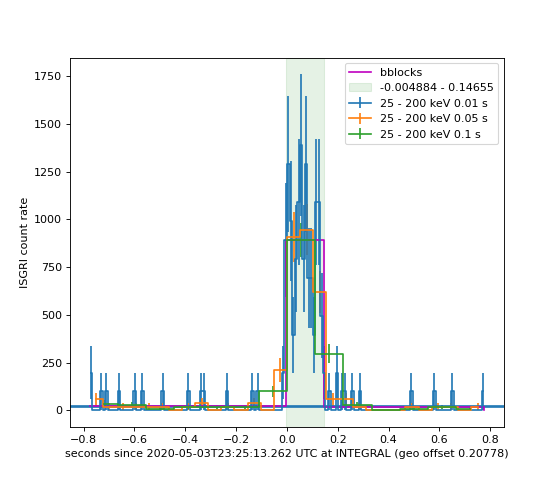

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 164
bins: [-7.75819083e-01 -7.65736776e-01 -7.55654469e-01 -7.45572162e-01
 -7.35489855e-01 -7.25407548e-01 -7.15325241e-01 -7.05242934e-01
 -6.95160627e-01 -6.85078320e-01 -6.74996013e-01 -6.64913706e-01
 -6.54831399e-01 -6.44749092e-01 -6.34666785e-01 -6.24584479e-01
 -6.14502172e-01 -6.04419865e-01 -5.94337558e-01 -5.84255251e-01
 -5.74172944e-01 -5.64090637e-01 -5.54008330e-01 -5.43926023e-01
 -5.33843716e-01 -5.23761409e-01 -5.13679102e-01 -5.03596795e-01
 -4.93514488e-01 -4.83432181e-01 -4.73349874e-01 -4.63267568e-01
 -4.53185261e-01 -4.43102954e-01 -4.33020647e-01 -4.22938340e-01
 -4.12856033e-01 -4.02773726e-01 -3.92691419e-01 -3.82609112e-01
 -3.72526805e-01 -3.62444498e-01 -3.52362191e-01 -3.42279884e-01
 -3.32197577e-01 -3.22115270e-01 -3.12032963e-01 -3.01950656e-01
 -2.91868350e-01 -2.81786043e-01 -2.71703736e-01 -2.61621429e-01
 -2.51539122e-01 -2.41456815e-01 -2.31374508e-01 -2.21292201e-01
 -2.11209894e-01 -2.01127587e-01 -1.91045280e-01 -1.80962973

{'t1_rel_s': -0.004884004010818899,
 't2_rel_s': 0.14654613041784614,
 'length_s': 0.15143013442866504,
 'bblock_success': True,
 'nevents_25_200': 136,
 'nevents_mgr50_25_200': 140,
 'bkg_pre_cts': 22.051143438034554,
 'bkg_post_cts': 19.03824934096321,
 'bkg_av_cts': 20.54469638949888,
 'nevents_bkg': 3.1110861360579247}

In [827]:
import re



def plot_one(t_refplot_utc):
    print(t_refplot_utc)
    sc = ic.get_sc(t_refplot_utc, ra=source_coord.ra.deg, dec=source_coord.dec.deg)
    dt_intgeo = sc['barytime']
    sc

    tc = ic.converttime("UTC", t_refplot_utc, "ANY")
    scwid = tc['SCWID']

    t_refplot_ijd = float(tc['IJD'])

    i_evts=fits.open("/mnt/sshfs/isdc-in01//unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2//byscw/{}/{}.000/evts_extract.v0//06aef025/source_evts.fits.gz".format(scwid[:4], scwid))[2].data
    i_evts_en=i_evts

    ebands = [(25,200)]

    plt.figure(figsize=(7,6))

    rates={}

    bins = 0.05

    #tbin = 0.01
    
    burst_data={}

    for e1,e2 in ebands:
        m = i_evts_en['ENERGY']>=e1
        m &= i_evts_en['ENERGY']<e2

        #t_plot_geo_s = (i_evts['TIME'] + dt_intgeo/24/3600 -t_refplot_ijd)*24*3600
        t_plot_s = (i_evts['TIME'] -t_refplot_ijd)*24*3600

        m &= np.abs(t_plot_s)<0.8

        m &= i_evts['PIF_1']>0.3

        print("events in selection", sum(m))

        
        for tbin in 0.01, 0.05, 0.1:
            _ts = t_plot_s[m]
            bins=np.linspace(_ts.min(), _ts.max(), int((_ts.max()-_ts.min())/tbin))

            print("bins:", bins)

            h = np.histogram(t_plot_s[m], bins=bins)

            tc = (h[1][1:] + h[1][:-1])*0.5
            dt = (h[1][1:] - h[1][:-1])
            rate = h[0]/dt
            rate_err = h[0]**0.5/dt

            rates[(e1,e2)] = dict(
                rate = rate,
                rate_err = rate_err,
                tc = tc,
                dt = dt,
            )

            if True:
                plt.errorbar(
                    tc,
                    rate,
                    rate_err,
                    ds="steps-mid",
                    label="%.5lg - %.5lg keV %.5lg s"%(e1,e2,tbin),
                )
            else:
                plt.step(
                    tc,
                    rate,
                    ds="steps-mid",
                    label="%.5lg - %.5lg keV"%(e1,e2),
                    alpha=0.5,
                )


        #edges = bayesian_blocks(t_plot_s[m])
    
        x = t_plot_s[m]
        
        import BayesBlocks

        bb = BayesBlocks.bblock(pd.DataFrame(dict(TIME=x)))
        bb.find_blocks(0.1)

        h_blocks = np.histogram(x,bins=x[bb.change_points])
        
        burst_data['t1_rel_s'] = h_blocks[1][1]
        burst_data['t2_rel_s'] = h_blocks[1][-2]
        burst_data['length_s'] = burst_data['t2_rel_s']-burst_data['t1_rel_s']
        
        burst_data['bblock_success'] = (burst_data['t2_rel_s']-burst_data['t1_rel_s'])<1.
        
        if not burst_data['bblock_success'] :
            plt.title("fail!")
        
        burst_data['nevents_%.5lg_%.5lg'%(e1,e2)] = sum( (x>=burst_data['t1_rel_s']) & (x<=burst_data['t2_rel_s']) ) 
        burst_data['nevents_mgr50_%.5lg_%.5lg'%(e1,e2)] = sum( (x>=burst_data['t1_rel_s']-0.05) & (x<=burst_data['t2_rel_s']+0.05) ) 
        
        burst_data['bkg_pre_cts'] = h_blocks[0][0]/(h_blocks[1][1]-h_blocks[1][0])
        burst_data['bkg_post_cts'] = h_blocks[0][-1]/(h_blocks[1][-1]-h_blocks[1][-2])
        burst_data['bkg_av_cts'] = (burst_data['bkg_post_cts'] + burst_data['bkg_pre_cts'])/2.
        burst_data['nevents_bkg'] = burst_data['bkg_av_cts'] * burst_data['length_s']
        
        plt.axvspan(burst_data['t1_rel_s'], burst_data['t2_rel_s'], alpha=0.1, color="g",
                   label="%.5lg - %.5lg"%(burst_data['t1_rel_s'], burst_data['t2_rel_s']))
        
        plt.axhline(burst_data['bkg_post_cts'])
        plt.axhline(burst_data['bkg_pre_cts'])
        
        plt.step( h_blocks[1],
                  np.concatenate([h_blocks[0]/(h_blocks[1][1:] - h_blocks[1][:-1]), [0]]),
                  color='m',
                  where='post',
                  label="bblocks"
                )
        
        
        #import BayesBlocks
        #BayesBlocks.find_blocks(pd.DataFrame())
    



    #plt.axvspan(
    #    (t_radio_p1_ijd - t_refplot_ijd)*24*3600 - radiotopo_s,
    #    (t_radio_p2_ijd - t_refplot_ijd)*24*3600 + radiotopo_s,
    #    alpha=0.2,
    #)

    #plt.axvline(
    #    (t_radio_detinf_ijd - t_refplot_ijd)*24*3600,
    #    alpha=0.5,
    #    label="radio ref",
    #    lw=2,
    #)


    #plt.axvline(
    #    (t_radio_p1_ijd - t_refplot_ijd)*24*3600,
    #    alpha=0.2,
    #    label="radio 1",
    #)


    #print("dt:")



    #plt.xlim([-0, 0.6])
    #plt.xlim([.40, 0.55])
    plt.ylabel("ISGRI count rate")
    plt.xlabel("seconds since "+t_refplot_utc+" UTC at INTEGRAL (geo offset %.5lg)"%dt_intgeo)

    plt.legend()

    fn = "draft/PAPER_SGR1935_INTEGRAL/data/burst-search/burst-plots/lc_peakandspec_{}.pdf".format(re.sub("[:]", "-", t_refplot_utc))
    plt.savefig(fn)
    plt.savefig(fn.replace(".pdf", ".png"))
    
    

    plt.show()
    
    return burst_data
    
    
    
plot_one("2020-05-03T23:25:13.262")




2020-04-28T03:47:52.164
2020-04-28T03:47:52.164
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:52.164/ANY


<IPython.core.display.Javascript object>


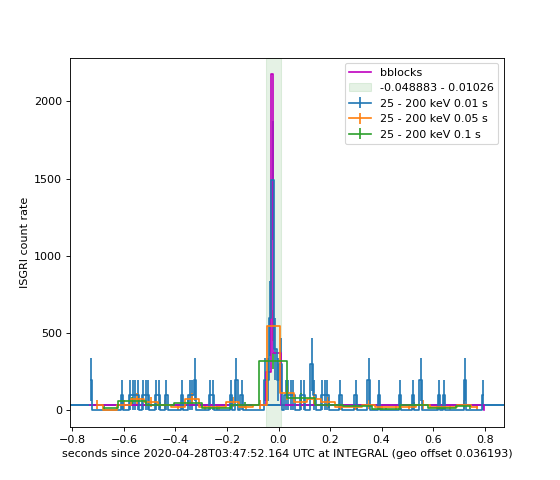

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 85
bins: [-0.73259887 -0.72252606 -0.71245326 -0.70238045 -0.69230764 -0.68223483
 -0.67216202 -0.66208922 -0.65201641 -0.6419436  -0.63187079 -0.62179798
 -0.61172517 -0.60165237 -0.59157956 -0.58150675 -0.57143394 -0.56136113
 -0.55128832 -0.54121552 -0.53114271 -0.5210699  -0.51099709 -0.50092428
 -0.49085147 -0.48077867 -0.47070586 -0.46063305 -0.45056024 -0.44048743
 -0.43041463 -0.42034182 -0.41026901 -0.4001962  -0.39012339 -0.38005058
 -0.36997778 -0.35990497 -0.34983216 -0.33975935 -0.32968654 -0.31961373
 -0.30954093 -0.29946812 -0.28939531 -0.2793225  -0.26924969 -0.25917689
 -0.24910408 -0.23903127 -0.22895846 -0.21888565 -0.20881284 -0.19874004
 -0.18866723 -0.17859442 -0.16852161 -0.1584488  -0.14837599 -0.13830319
 -0.12823038 -0.11815757 -0.10808476 -0.09801195 -0.08793915 -0.07786634
 -0.06779353 -0.05772072 -0.04764791 -0.0375751  -0.0275023  -0.01742949
 -0.00735668  0.00271613  0.01278894  0.02286175  0.03293455  0.04300736
  0.05308017  0.063152

<IPython.core.display.Javascript object>


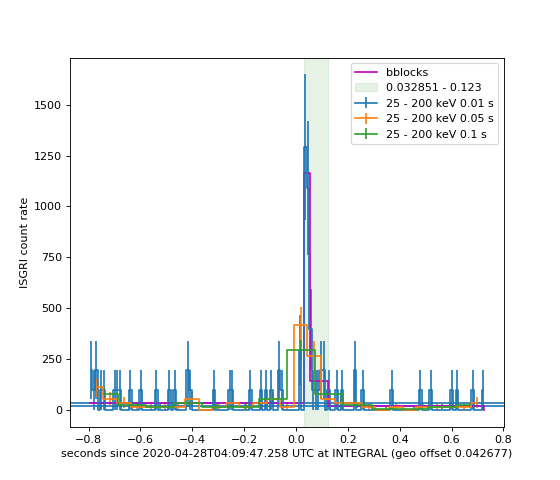

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 79
bins: [-7.95457567e-01 -7.85379895e-01 -7.75302223e-01 -7.65224550e-01
 -7.55146878e-01 -7.45069206e-01 -7.34991533e-01 -7.24913861e-01
 -7.14836189e-01 -7.04758516e-01 -6.94680844e-01 -6.84603172e-01
 -6.74525499e-01 -6.64447827e-01 -6.54370155e-01 -6.44292482e-01
 -6.34214810e-01 -6.24137138e-01 -6.14059465e-01 -6.03981793e-01
 -5.93904121e-01 -5.83826448e-01 -5.73748776e-01 -5.63671104e-01
 -5.53593431e-01 -5.43515759e-01 -5.33438087e-01 -5.23360414e-01
 -5.13282742e-01 -5.03205070e-01 -4.93127397e-01 -4.83049725e-01
 -4.72972053e-01 -4.62894380e-01 -4.52816708e-01 -4.42739036e-01
 -4.32661363e-01 -4.22583691e-01 -4.12506019e-01 -4.02428346e-01
 -3.92350674e-01 -3.82273002e-01 -3.72195329e-01 -3.62117657e-01
 -3.52039985e-01 -3.41962312e-01 -3.31884640e-01 -3.21806968e-01
 -3.11729295e-01 -3.01651623e-01 -2.91573951e-01 -2.81496278e-01
 -2.71418606e-01 -2.61340934e-01 -2.51263261e-01 -2.41185589e-01
 -2.31107917e-01 -2.21030244e-01 -2.10952572e-01 -2.00874900e

<IPython.core.display.Javascript object>


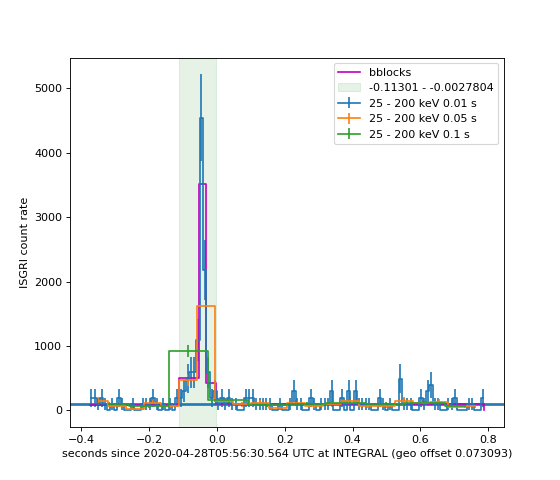

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 214
bins: [-3.75096820e-01 -3.64978248e-01 -3.54859676e-01 -3.44741104e-01
 -3.34622532e-01 -3.24503960e-01 -3.14385388e-01 -3.04266816e-01
 -2.94148244e-01 -2.84029672e-01 -2.73911100e-01 -2.63792528e-01
 -2.53673956e-01 -2.43555384e-01 -2.33436812e-01 -2.23318240e-01
 -2.13199668e-01 -2.03081096e-01 -1.92962524e-01 -1.82843952e-01
 -1.72725380e-01 -1.62606808e-01 -1.52488236e-01 -1.42369664e-01
 -1.32251092e-01 -1.22132520e-01 -1.12013948e-01 -1.01895376e-01
 -9.17768038e-02 -8.16582317e-02 -7.15396597e-02 -6.14210877e-02
 -5.13025157e-02 -4.11839437e-02 -3.10653717e-02 -2.09467997e-02
 -1.08282277e-02 -7.09655654e-04  9.40891636e-03  1.95274884e-02
  2.96460604e-02  3.97646324e-02  4.98832044e-02  6.00017764e-02
  7.01203484e-02  8.02389204e-02  9.03574924e-02  1.00476064e-01
  1.10594636e-01  1.20713208e-01  1.30831780e-01  1.40950353e-01
  1.51068925e-01  1.61187497e-01  1.71306069e-01  1.81424641e-01
  1.91543213e-01  2.01661785e-01  2.11780357e-01  2.21898929

<IPython.core.display.Javascript object>


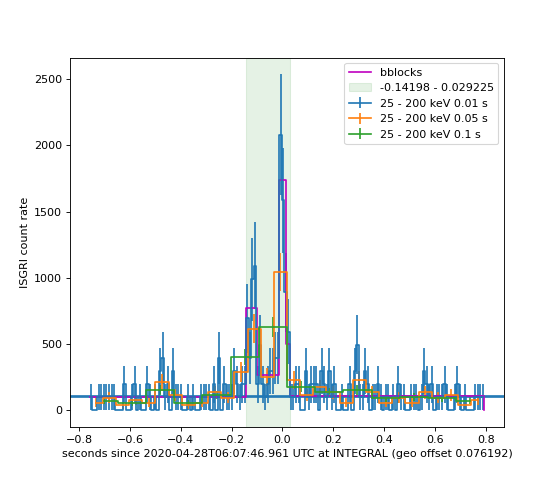

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 256
bins: [-0.75886058 -0.74877273 -0.73868489 -0.72859704 -0.71850919 -0.70842134
 -0.6983335  -0.68824565 -0.6781578  -0.66806995 -0.65798211 -0.64789426
 -0.63780641 -0.62771856 -0.61763072 -0.60754287 -0.59745502 -0.58736718
 -0.57727933 -0.56719148 -0.55710363 -0.54701579 -0.53692794 -0.52684009
 -0.51675224 -0.5066644  -0.49657655 -0.4864887  -0.47640085 -0.46631301
 -0.45622516 -0.44613731 -0.43604946 -0.42596162 -0.41587377 -0.40578592
 -0.39569808 -0.38561023 -0.37552238 -0.36543453 -0.35534669 -0.34525884
 -0.33517099 -0.32508314 -0.3149953  -0.30490745 -0.2948196  -0.28473175
 -0.27464391 -0.26455606 -0.25446821 -0.24438036 -0.23429252 -0.22420467
 -0.21411682 -0.20402898 -0.19394113 -0.18385328 -0.17376543 -0.16367759
 -0.15358974 -0.14350189 -0.13341404 -0.1233262  -0.11323835 -0.1031505
 -0.09306265 -0.08297481 -0.07288696 -0.06279911 -0.05271126 -0.04262342
 -0.03253557 -0.02244772 -0.01235988 -0.00227203  0.00781582  0.01790367
  0.02799151  0.038079

<IPython.core.display.Javascript object>


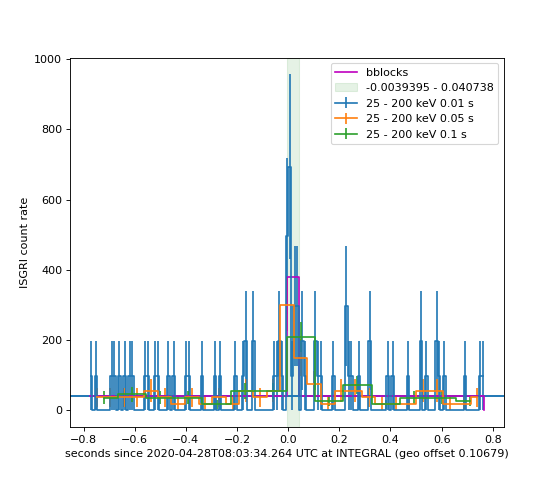

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 78
bins: [-7.75853108e-01 -7.65771524e-01 -7.55689940e-01 -7.45608355e-01
 -7.35526771e-01 -7.25445187e-01 -7.15363603e-01 -7.05282019e-01
 -6.95200435e-01 -6.85118850e-01 -6.75037266e-01 -6.64955682e-01
 -6.54874098e-01 -6.44792514e-01 -6.34710930e-01 -6.24629345e-01
 -6.14547761e-01 -6.04466177e-01 -5.94384593e-01 -5.84303009e-01
 -5.74221425e-01 -5.64139841e-01 -5.54058256e-01 -5.43976672e-01
 -5.33895088e-01 -5.23813504e-01 -5.13731920e-01 -5.03650336e-01
 -4.93568751e-01 -4.83487167e-01 -4.73405583e-01 -4.63323999e-01
 -4.53242415e-01 -4.43160831e-01 -4.33079246e-01 -4.22997662e-01
 -4.12916078e-01 -4.02834494e-01 -3.92752910e-01 -3.82671326e-01
 -3.72589741e-01 -3.62508157e-01 -3.52426573e-01 -3.42344989e-01
 -3.32263405e-01 -3.22181821e-01 -3.12100236e-01 -3.02018652e-01
 -2.91937068e-01 -2.81855484e-01 -2.71773900e-01 -2.61692316e-01
 -2.51610732e-01 -2.41529147e-01 -2.31447563e-01 -2.21365979e-01
 -2.11284395e-01 -2.01202811e-01 -1.91121227e-01 -1.81039642e

<IPython.core.display.Javascript object>


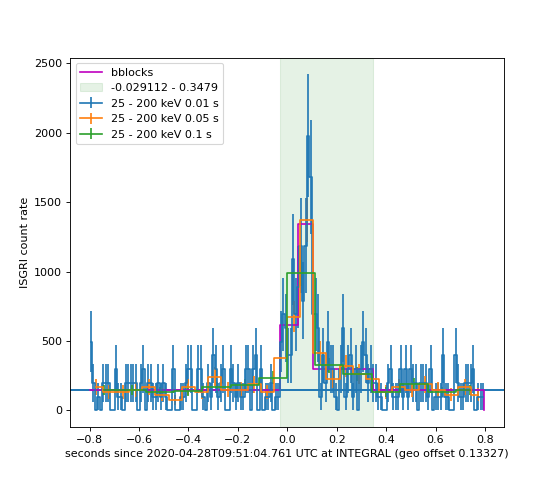

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 381
bins: [-0.79968275 -0.78957487 -0.77946698 -0.76935909 -0.7592512  -0.74914331
 -0.73903542 -0.72892754 -0.71881965 -0.70871176 -0.69860387 -0.68849598
 -0.67838809 -0.6682802  -0.65817232 -0.64806443 -0.63795654 -0.62784865
 -0.61774076 -0.60763287 -0.59752499 -0.5874171  -0.57730921 -0.56720132
 -0.55709343 -0.54698554 -0.53687766 -0.52676977 -0.51666188 -0.50655399
 -0.4964461  -0.48633821 -0.47623033 -0.46612244 -0.45601455 -0.44590666
 -0.43579877 -0.42569088 -0.41558299 -0.40547511 -0.39536722 -0.38525933
 -0.37515144 -0.36504355 -0.35493566 -0.34482778 -0.33471989 -0.324612
 -0.31450411 -0.30439622 -0.29428833 -0.28418045 -0.27407256 -0.26396467
 -0.25385678 -0.24374889 -0.233641   -0.22353312 -0.21342523 -0.20331734
 -0.19320945 -0.18310156 -0.17299367 -0.16288579 -0.1527779  -0.14267001
 -0.13256212 -0.12245423 -0.11234634 -0.10223845 -0.09213057 -0.08202268
 -0.07191479 -0.0618069  -0.05169901 -0.04159112 -0.03148324 -0.02137535
 -0.01126746 -0.0011595

<IPython.core.display.Javascript object>


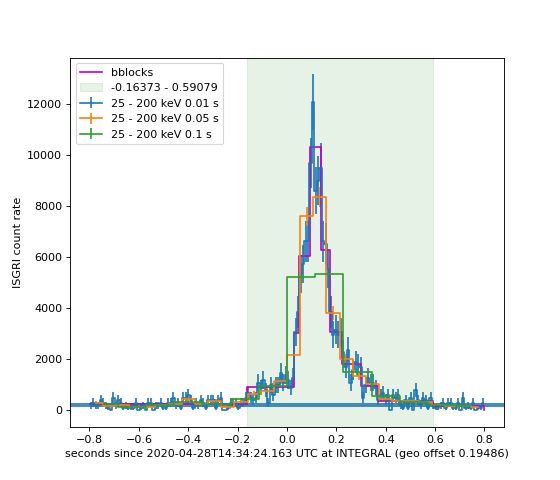

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 1818
bins: [-7.98981267e-01 -7.88866802e-01 -7.78752338e-01 -7.68637873e-01
 -7.58523408e-01 -7.48408943e-01 -7.38294479e-01 -7.28180014e-01
 -7.18065549e-01 -7.07951084e-01 -6.97836619e-01 -6.87722155e-01
 -6.77607690e-01 -6.67493225e-01 -6.57378760e-01 -6.47264296e-01
 -6.37149831e-01 -6.27035366e-01 -6.16920901e-01 -6.06806436e-01
 -5.96691972e-01 -5.86577507e-01 -5.76463042e-01 -5.66348577e-01
 -5.56234113e-01 -5.46119648e-01 -5.36005183e-01 -5.25890718e-01
 -5.15776254e-01 -5.05661789e-01 -4.95547324e-01 -4.85432859e-01
 -4.75318394e-01 -4.65203930e-01 -4.55089465e-01 -4.44975000e-01
 -4.34860535e-01 -4.24746071e-01 -4.14631606e-01 -4.04517141e-01
 -3.94402676e-01 -3.84288212e-01 -3.74173747e-01 -3.64059282e-01
 -3.53944817e-01 -3.43830352e-01 -3.33715888e-01 -3.23601423e-01
 -3.13486958e-01 -3.03372493e-01 -2.93258029e-01 -2.83143564e-01
 -2.73029099e-01 -2.62914634e-01 -2.52800169e-01 -2.42685705e-01
 -2.32571240e-01 -2.22456775e-01 -2.12342310e-01 -2.0222784

<IPython.core.display.Javascript object>


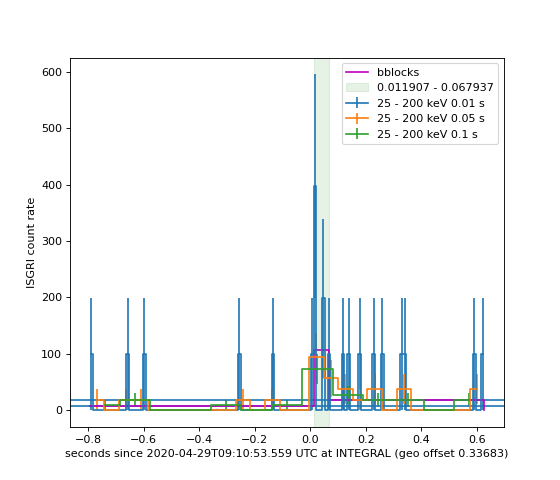

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 22
bins: [-0.79485564 -0.78477445 -0.77469326 -0.76461207 -0.75453088 -0.74444969
 -0.7343685  -0.72428731 -0.71420612 -0.70412493 -0.69404375 -0.68396256
 -0.67388137 -0.66380018 -0.65371899 -0.6436378  -0.63355661 -0.62347542
 -0.61339423 -0.60331304 -0.59323185 -0.58315066 -0.57306947 -0.56298828
 -0.55290709 -0.5428259  -0.53274471 -0.52266352 -0.51258233 -0.50250114
 -0.49241995 -0.48233876 -0.47225757 -0.46217638 -0.45209519 -0.442014
 -0.43193281 -0.42185162 -0.41177043 -0.40168924 -0.39160805 -0.38152686
 -0.37144567 -0.36136449 -0.3512833  -0.34120211 -0.33112092 -0.32103973
 -0.31095854 -0.30087735 -0.29079616 -0.28071497 -0.27063378 -0.26055259
 -0.2504714  -0.24039021 -0.23030902 -0.22022783 -0.21014664 -0.20006545
 -0.18998426 -0.17990307 -0.16982188 -0.15974069 -0.1496595  -0.13957831
 -0.12949712 -0.11941593 -0.10933474 -0.09925355 -0.08917236 -0.07909117
 -0.06900998 -0.05892879 -0.0488476  -0.03876641 -0.02868523 -0.01860404
 -0.00852285  0.00155834

<IPython.core.display.Javascript object>


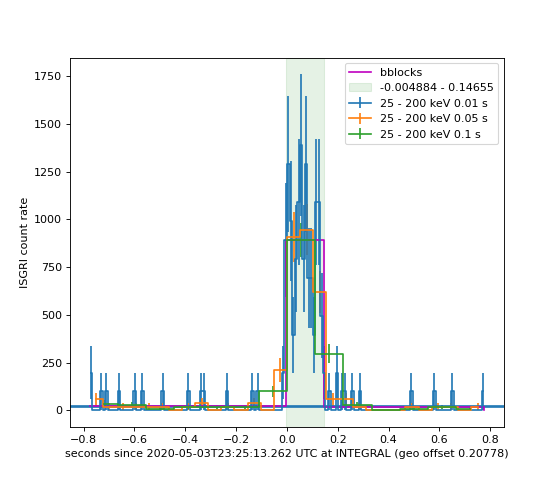

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 164
bins: [-7.75819083e-01 -7.65736776e-01 -7.55654469e-01 -7.45572162e-01
 -7.35489855e-01 -7.25407548e-01 -7.15325241e-01 -7.05242934e-01
 -6.95160627e-01 -6.85078320e-01 -6.74996013e-01 -6.64913706e-01
 -6.54831399e-01 -6.44749092e-01 -6.34666785e-01 -6.24584479e-01
 -6.14502172e-01 -6.04419865e-01 -5.94337558e-01 -5.84255251e-01
 -5.74172944e-01 -5.64090637e-01 -5.54008330e-01 -5.43926023e-01
 -5.33843716e-01 -5.23761409e-01 -5.13679102e-01 -5.03596795e-01
 -4.93514488e-01 -4.83432181e-01 -4.73349874e-01 -4.63267568e-01
 -4.53185261e-01 -4.43102954e-01 -4.33020647e-01 -4.22938340e-01
 -4.12856033e-01 -4.02773726e-01 -3.92691419e-01 -3.82609112e-01
 -3.72526805e-01 -3.62444498e-01 -3.52362191e-01 -3.42279884e-01
 -3.32197577e-01 -3.22115270e-01 -3.12032963e-01 -3.01950656e-01
 -2.91868350e-01 -2.81786043e-01 -2.71703736e-01 -2.61621429e-01
 -2.51539122e-01 -2.41456815e-01 -2.31374508e-01 -2.21292201e-01
 -2.11209894e-01 -2.01127587e-01 -1.91045280e-01 -1.80962973

In [495]:
for burst in bursts:
    print(burst['utc_integral'])
    
    burst['bblocks'] = plot_one(burst['utc_integral'])

In [702]:
_bursts=[]
for b in bursts:
    if 'bblocks' not in b:
        continue
    
    if b['bblocks']['t2_rel_s']-b['bblocks']['t1_rel_s'] > 1.:
        print(b['utc_integral'], "skipping", b['utc_integral'])
        continue
    
    if b['bblocks']['t2_rel_s']-b['bblocks']['t1_rel_s'] < 0:
        print(b['utc_integral'], "skipping", b['utc_integral'])
        continue
        
    print(b['utc_integral'], "this is ok:", b['bblocks']['t1_rel_s'], b['bblocks']['t2_rel_s'])
    
    _bursts.append(b)

bursts = _bursts
   

2020-04-28T03:47:52.164 this is ok: -0.04888310213573277 0.010259999544359744
2020-04-28T04:09:47.258 this is ok: 0.03285059065092355 0.12299945228733122
2020-04-28T05:56:30.564 this is ok: -0.11300992628093809 -0.0027804082492366433
2020-04-28T06:07:46.961 this is ok: -0.14197825512383133 0.029225365142337978
2020-04-28T08:03:34.264 this is ok: -0.003939546877518296 0.040738171082921326
2020-04-28T09:51:04.761 this is ok: -0.029111973708495498 0.3479007922578603
2020-04-28T14:34:24.163 this is ok: -0.16372732934542 0.5907911370741203
2020-04-29T09:10:53.559 this is ok: 0.011907043517567217 0.0679372635204345
2020-05-03T23:25:13.262 this is ok: -0.004884004010818899 0.14654613041784614


In [918]:
import simplify
importlib.reload(simplify)

print(simplify.__file__)


/mnt/nvme0n1p5/home/savchenk/work/SGR_1935_2154/simplify.py


In [706]:
_bursts[0]['hratio_err']

0.7906127619451656

In [711]:
import json, ast

In [829]:

fit_results = yaml.load(open("draft/PAPER_SGR1935_INTEGRAL/data/spectra/fit_results.yaml"))
fit_results

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'2020-04-28T03-47-52.164': {'PhoIndex__01': [3.0349406660499945,
   2.404672445469558,
   3.899411185445984],
  'cstat': [2.7543128283339406, 2],
  'flux': (1.9033754361343834e-06,
   1.5513103589788575e-06,
   2.4021879142213615e-06),
  'luminosity': [2.27737954e+40, 1.85613537e+40, 2.87420627e+40],
  'norm__04': [1902598.0377656706, 1550164.009051996, 2403932.1148561104],
  'rate': [17164.0771484375, 13921.652574194326, 20406.501722680674],
  'times': [3.797823333333335, 3.7978394736111127]},
 '2020-04-28T04-09-47.258': {'PhoIndex__01': [2.451426681620527,
   1.448265176808508,
   3.8971873099243166],
  'cstat': [0.6007568112106002, 2],
  'flux': (1.0585680833996035e-06,
   8.172269346778097e-07,
   1.4581630452600215e-06),
  'luminosity': [1.26657161e+40, 9.77808091e+39, 1.74468506e+40],
  'norm__04': [1058283.8125201582, 836674.6972449784, 1468882.6073138644],
  'rate': [9342.411682128906, 7193.508172160224, 11491.315192097589],
  'times': [4.163127222222224, 4.163152043055557]},


In [832]:
# ad this data !

bursts = yaml.load(open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts_search.yaml"))

for b in bursts:
    print(b['utc_integral'], b['detections'])
    
    mbs = [_b for _b in _bursts if b['utc_integral'] == _b['utc_integral']]
    
    if len(mbs) == 0: continue
    
    mb=mbs[0]
    
    print("adding..")
    
    fr = [fr for fr in fit_results.items() if b['utc_integral'].replace(":", "-") == fr[0]][0]

    
    b['fit']=fr[1]
    
    b['fit']['Gamma'] = dict(
        mean=b['fit']['PhoIndex__01'][0],
        stat_err_minus=b['fit']['PhoIndex__01'][0]-b['fit']['PhoIndex__01'][1],
        stat_err_plus=b['fit']['PhoIndex__01'][2]-b['fit']['PhoIndex__01'][0],
    )
    
    b.update({k:v for k,v in mb.items() if k not in ['detections']})
    

yaml.dump(
    sorted(simplify.simplify(bursts), key=lambda x:x['ijd']), 
    open("draft/PAPER_SGR1935_INTEGRAL/data/burst-search/bursts.yaml", "w"))

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


2020-04-28T03:47:52.164 ['ISGRI offline']
adding..
2020-04-28T04:09:47.258 ['ISGRI offline']
adding..
2020-04-28T05:56:30.564 ['ISGRI offline']
adding..
2020-04-28T06:07:46.961 ['ISGRI offline']
adding..
2020-04-28T08:03:34.264 ['ISGRI offline']
adding..
2020-04-28T09:51:04.761 ['ISGRI offline', 'IBAS']
adding..
2020-04-28T14:34:24.163 ['ISGRI offline', 'IBAS', 'ACS', 'CHIME', 'STARE2']
adding..
2020-04-29T05:28:33.565 ['ISGRI offline']
2020-04-29T09:10:53.559 ['ISGRI offline']
adding..
2020-05-03T23:25:13.262 ['ISGRI offline']
adding..
2020-05-04T23:04:02.065 ['ISGRI offline']
2020-05-04T23:28:42.558 ['ISGRI offline']
2020-04-30T21:41:51.244 ['FAST']


In [746]:
bursts[0]['fit']['Gamma']

{'mean': 3.0349406660499945,
 'stat_err_minus': 0.6302682205804366,
 'stat_err_plus': 0.8644705193959896}

In [833]:
bursts[0]['image_results']

{(-0.04888310213573277,
  0.010259999544359744): <ddaclient.DDOSAproduct at 0x7ff39962fef0>,
 (-0.14888310213573278,
  0.11025999954435975): <ddaclient.DDOSAproduct at 0x7ff3995533c8>}

2020-04-28T03:47:52.164
url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem//api/v1.0/converttime/UTC/2020-04-28T03:47:52.164/ANY


<IPython.core.display.Javascript object>


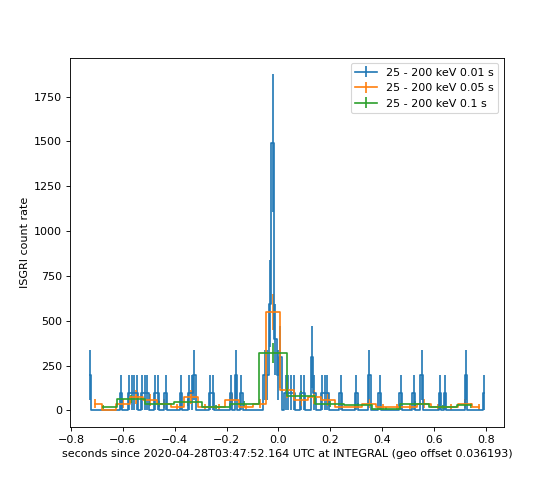

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 85
bins: [-0.73259887 -0.72252606 -0.71245326 -0.70238045 -0.69230764 -0.68223483
 -0.67216202 -0.66208922 -0.65201641 -0.6419436  -0.63187079 -0.62179798
 -0.61172517 -0.60165237 -0.59157956 -0.58150675 -0.57143394 -0.56136113
 -0.55128832 -0.54121552 -0.53114271 -0.5210699  -0.51099709 -0.50092428
 -0.49085147 -0.48077867 -0.47070586 -0.46063305 -0.45056024 -0.44048743
 -0.43041463 -0.42034182 -0.41026901 -0.4001962  -0.39012339 -0.38005058
 -0.36997778 -0.35990497 -0.34983216 -0.33975935 -0.32968654 -0.31961373
 -0.30954093 -0.29946812 -0.28939531 -0.2793225  -0.26924969 -0.25917689
 -0.24910408 -0.23903127 -0.22895846 -0.21888565 -0.20881284 -0.19874004
 -0.18866723 -0.17859442 -0.16852161 -0.1584488  -0.14837599 -0.13830319
 -0.12823038 -0.11815757 -0.10808476 -0.09801195 -0.08793915 -0.07786634
 -0.06779353 -0.05772072 -0.04764791 -0.0375751  -0.0275023  -0.01742949
 -0.00735668  0.00271613  0.01278894  0.02286175  0.03293455  0.04300736
  0.05308017  0.063152

<IPython.core.display.Javascript object>


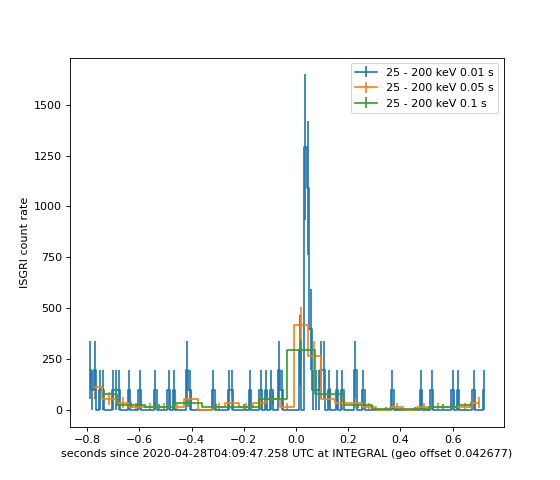

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 79
bins: [-7.95457567e-01 -7.85379895e-01 -7.75302223e-01 -7.65224550e-01
 -7.55146878e-01 -7.45069206e-01 -7.34991533e-01 -7.24913861e-01
 -7.14836189e-01 -7.04758516e-01 -6.94680844e-01 -6.84603172e-01
 -6.74525499e-01 -6.64447827e-01 -6.54370155e-01 -6.44292482e-01
 -6.34214810e-01 -6.24137138e-01 -6.14059465e-01 -6.03981793e-01
 -5.93904121e-01 -5.83826448e-01 -5.73748776e-01 -5.63671104e-01
 -5.53593431e-01 -5.43515759e-01 -5.33438087e-01 -5.23360414e-01
 -5.13282742e-01 -5.03205070e-01 -4.93127397e-01 -4.83049725e-01
 -4.72972053e-01 -4.62894380e-01 -4.52816708e-01 -4.42739036e-01
 -4.32661363e-01 -4.22583691e-01 -4.12506019e-01 -4.02428346e-01
 -3.92350674e-01 -3.82273002e-01 -3.72195329e-01 -3.62117657e-01
 -3.52039985e-01 -3.41962312e-01 -3.31884640e-01 -3.21806968e-01
 -3.11729295e-01 -3.01651623e-01 -2.91573951e-01 -2.81496278e-01
 -2.71418606e-01 -2.61340934e-01 -2.51263261e-01 -2.41185589e-01
 -2.31107917e-01 -2.21030244e-01 -2.10952572e-01 -2.00874900e

<IPython.core.display.Javascript object>


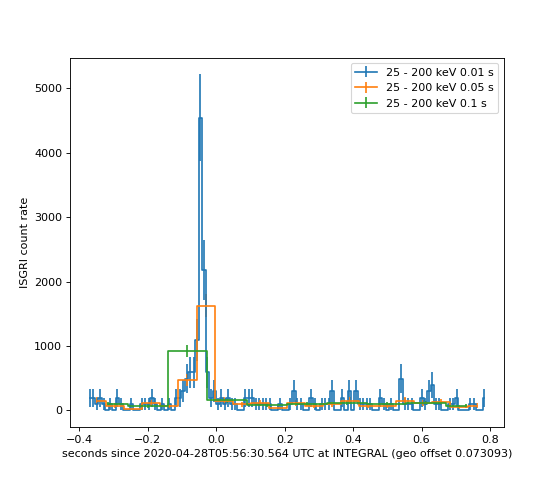

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 214
bins: [-3.75096820e-01 -3.64978248e-01 -3.54859676e-01 -3.44741104e-01
 -3.34622532e-01 -3.24503960e-01 -3.14385388e-01 -3.04266816e-01
 -2.94148244e-01 -2.84029672e-01 -2.73911100e-01 -2.63792528e-01
 -2.53673956e-01 -2.43555384e-01 -2.33436812e-01 -2.23318240e-01
 -2.13199668e-01 -2.03081096e-01 -1.92962524e-01 -1.82843952e-01
 -1.72725380e-01 -1.62606808e-01 -1.52488236e-01 -1.42369664e-01
 -1.32251092e-01 -1.22132520e-01 -1.12013948e-01 -1.01895376e-01
 -9.17768038e-02 -8.16582317e-02 -7.15396597e-02 -6.14210877e-02
 -5.13025157e-02 -4.11839437e-02 -3.10653717e-02 -2.09467997e-02
 -1.08282277e-02 -7.09655654e-04  9.40891636e-03  1.95274884e-02
  2.96460604e-02  3.97646324e-02  4.98832044e-02  6.00017764e-02
  7.01203484e-02  8.02389204e-02  9.03574924e-02  1.00476064e-01
  1.10594636e-01  1.20713208e-01  1.30831780e-01  1.40950353e-01
  1.51068925e-01  1.61187497e-01  1.71306069e-01  1.81424641e-01
  1.91543213e-01  2.01661785e-01  2.11780357e-01  2.21898929

<IPython.core.display.Javascript object>


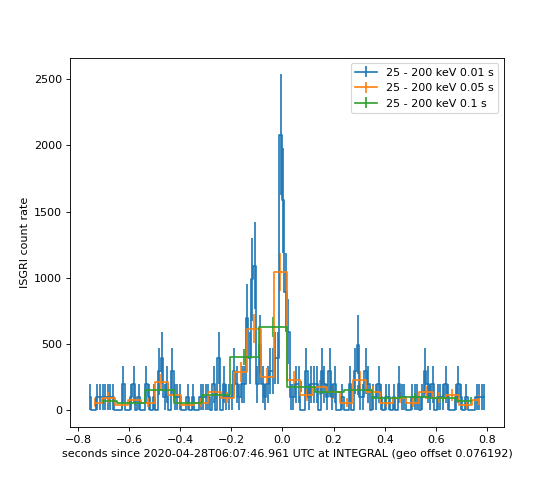

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 256
bins: [-0.75886058 -0.74877273 -0.73868489 -0.72859704 -0.71850919 -0.70842134
 -0.6983335  -0.68824565 -0.6781578  -0.66806995 -0.65798211 -0.64789426
 -0.63780641 -0.62771856 -0.61763072 -0.60754287 -0.59745502 -0.58736718
 -0.57727933 -0.56719148 -0.55710363 -0.54701579 -0.53692794 -0.52684009
 -0.51675224 -0.5066644  -0.49657655 -0.4864887  -0.47640085 -0.46631301
 -0.45622516 -0.44613731 -0.43604946 -0.42596162 -0.41587377 -0.40578592
 -0.39569808 -0.38561023 -0.37552238 -0.36543453 -0.35534669 -0.34525884
 -0.33517099 -0.32508314 -0.3149953  -0.30490745 -0.2948196  -0.28473175
 -0.27464391 -0.26455606 -0.25446821 -0.24438036 -0.23429252 -0.22420467
 -0.21411682 -0.20402898 -0.19394113 -0.18385328 -0.17376543 -0.16367759
 -0.15358974 -0.14350189 -0.13341404 -0.1233262  -0.11323835 -0.1031505
 -0.09306265 -0.08297481 -0.07288696 -0.06279911 -0.05271126 -0.04262342
 -0.03253557 -0.02244772 -0.01235988 -0.00227203  0.00781582  0.01790367
  0.02799151  0.038079

<IPython.core.display.Javascript object>


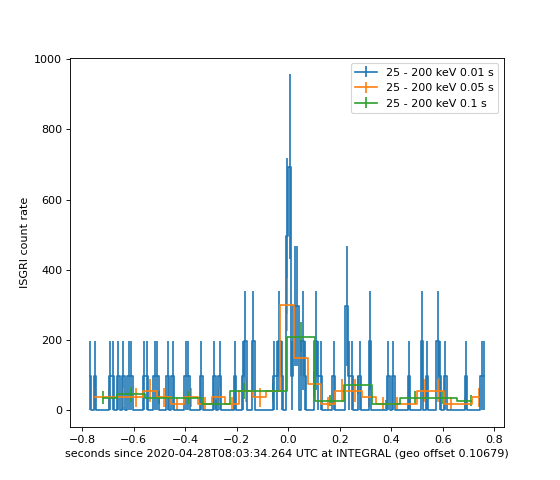

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 78
bins: [-7.75853108e-01 -7.65771524e-01 -7.55689940e-01 -7.45608355e-01
 -7.35526771e-01 -7.25445187e-01 -7.15363603e-01 -7.05282019e-01
 -6.95200435e-01 -6.85118850e-01 -6.75037266e-01 -6.64955682e-01
 -6.54874098e-01 -6.44792514e-01 -6.34710930e-01 -6.24629345e-01
 -6.14547761e-01 -6.04466177e-01 -5.94384593e-01 -5.84303009e-01
 -5.74221425e-01 -5.64139841e-01 -5.54058256e-01 -5.43976672e-01
 -5.33895088e-01 -5.23813504e-01 -5.13731920e-01 -5.03650336e-01
 -4.93568751e-01 -4.83487167e-01 -4.73405583e-01 -4.63323999e-01
 -4.53242415e-01 -4.43160831e-01 -4.33079246e-01 -4.22997662e-01
 -4.12916078e-01 -4.02834494e-01 -3.92752910e-01 -3.82671326e-01
 -3.72589741e-01 -3.62508157e-01 -3.52426573e-01 -3.42344989e-01
 -3.32263405e-01 -3.22181821e-01 -3.12100236e-01 -3.02018652e-01
 -2.91937068e-01 -2.81855484e-01 -2.71773900e-01 -2.61692316e-01
 -2.51610732e-01 -2.41529147e-01 -2.31447563e-01 -2.21365979e-01
 -2.11284395e-01 -2.01202811e-01 -1.91121227e-01 -1.81039642e

<IPython.core.display.Javascript object>


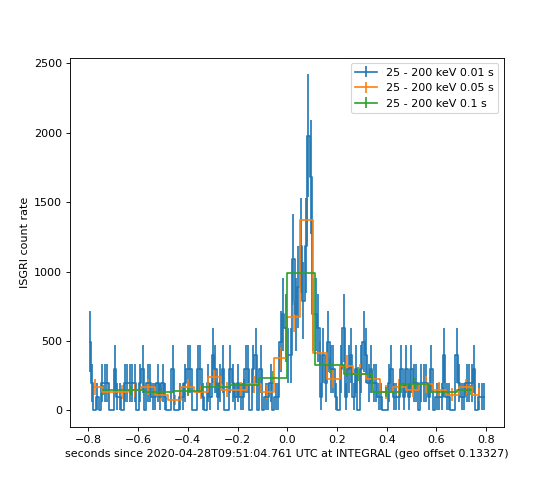

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 381
bins: [-0.79968275 -0.78957487 -0.77946698 -0.76935909 -0.7592512  -0.74914331
 -0.73903542 -0.72892754 -0.71881965 -0.70871176 -0.69860387 -0.68849598
 -0.67838809 -0.6682802  -0.65817232 -0.64806443 -0.63795654 -0.62784865
 -0.61774076 -0.60763287 -0.59752499 -0.5874171  -0.57730921 -0.56720132
 -0.55709343 -0.54698554 -0.53687766 -0.52676977 -0.51666188 -0.50655399
 -0.4964461  -0.48633821 -0.47623033 -0.46612244 -0.45601455 -0.44590666
 -0.43579877 -0.42569088 -0.41558299 -0.40547511 -0.39536722 -0.38525933
 -0.37515144 -0.36504355 -0.35493566 -0.34482778 -0.33471989 -0.324612
 -0.31450411 -0.30439622 -0.29428833 -0.28418045 -0.27407256 -0.26396467
 -0.25385678 -0.24374889 -0.233641   -0.22353312 -0.21342523 -0.20331734
 -0.19320945 -0.18310156 -0.17299367 -0.16288579 -0.1527779  -0.14267001
 -0.13256212 -0.12245423 -0.11234634 -0.10223845 -0.09213057 -0.08202268
 -0.07191479 -0.0618069  -0.05169901 -0.04159112 -0.03148324 -0.02137535
 -0.01126746 -0.0011595

<IPython.core.display.Javascript object>


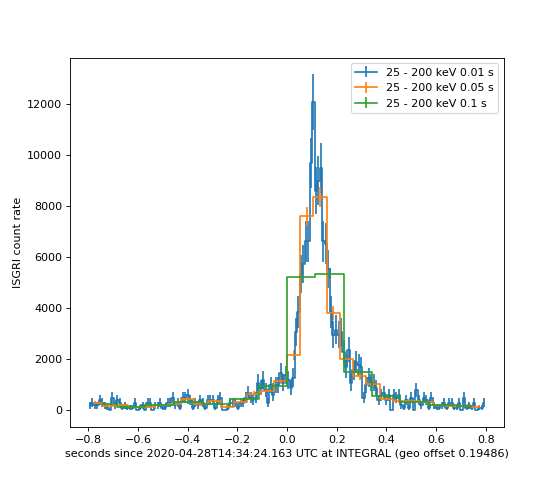

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 1818
bins: [-7.98981267e-01 -7.88866802e-01 -7.78752338e-01 -7.68637873e-01
 -7.58523408e-01 -7.48408943e-01 -7.38294479e-01 -7.28180014e-01
 -7.18065549e-01 -7.07951084e-01 -6.97836619e-01 -6.87722155e-01
 -6.77607690e-01 -6.67493225e-01 -6.57378760e-01 -6.47264296e-01
 -6.37149831e-01 -6.27035366e-01 -6.16920901e-01 -6.06806436e-01
 -5.96691972e-01 -5.86577507e-01 -5.76463042e-01 -5.66348577e-01
 -5.56234113e-01 -5.46119648e-01 -5.36005183e-01 -5.25890718e-01
 -5.15776254e-01 -5.05661789e-01 -4.95547324e-01 -4.85432859e-01
 -4.75318394e-01 -4.65203930e-01 -4.55089465e-01 -4.44975000e-01
 -4.34860535e-01 -4.24746071e-01 -4.14631606e-01 -4.04517141e-01
 -3.94402676e-01 -3.84288212e-01 -3.74173747e-01 -3.64059282e-01
 -3.53944817e-01 -3.43830352e-01 -3.33715888e-01 -3.23601423e-01
 -3.13486958e-01 -3.03372493e-01 -2.93258029e-01 -2.83143564e-01
 -2.73029099e-01 -2.62914634e-01 -2.52800169e-01 -2.42685705e-01
 -2.32571240e-01 -2.22456775e-01 -2.12342310e-01 -2.0222784

<IPython.core.display.Javascript object>


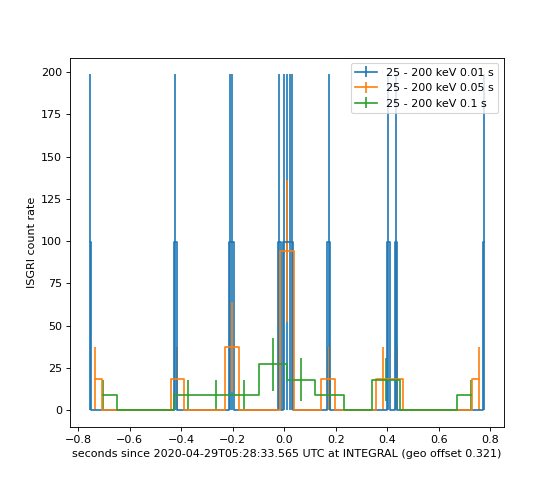

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 13
bins: [-0.75946974 -0.74939614 -0.73932255 -0.72924896 -0.71917536 -0.70910177
 -0.69902818 -0.68895458 -0.67888099 -0.6688074  -0.6587338  -0.64866021
 -0.63858662 -0.62851302 -0.61843943 -0.60836584 -0.59829225 -0.58821865
 -0.57814506 -0.56807147 -0.55799787 -0.54792428 -0.53785069 -0.52777709
 -0.5177035  -0.50762991 -0.49755631 -0.48748272 -0.47740913 -0.46733554
 -0.45726194 -0.44718835 -0.43711476 -0.42704116 -0.41696757 -0.40689398
 -0.39682038 -0.38674679 -0.3766732  -0.3665996  -0.35652601 -0.34645242
 -0.33637882 -0.32630523 -0.31623164 -0.30615805 -0.29608445 -0.28601086
 -0.27593727 -0.26586367 -0.25579008 -0.24571649 -0.23564289 -0.2255693
 -0.21549571 -0.20542211 -0.19534852 -0.18527493 -0.17520134 -0.16512774
 -0.15505415 -0.14498056 -0.13490696 -0.12483337 -0.11475978 -0.10468618
 -0.09461259 -0.084539   -0.0744654  -0.06439181 -0.05431822 -0.04424462
 -0.03417103 -0.02409744 -0.01402385 -0.00395025  0.00612334  0.01619693
  0.02627053  0.0363441

<IPython.core.display.Javascript object>


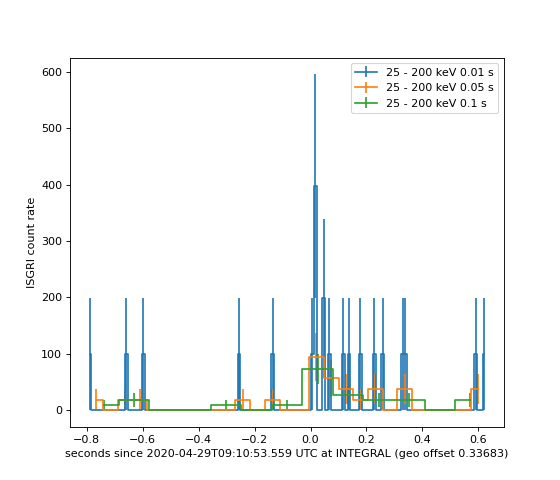

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 22
bins: [-0.79485564 -0.78477445 -0.77469326 -0.76461207 -0.75453088 -0.74444969
 -0.7343685  -0.72428731 -0.71420612 -0.70412493 -0.69404375 -0.68396256
 -0.67388137 -0.66380018 -0.65371899 -0.6436378  -0.63355661 -0.62347542
 -0.61339423 -0.60331304 -0.59323185 -0.58315066 -0.57306947 -0.56298828
 -0.55290709 -0.5428259  -0.53274471 -0.52266352 -0.51258233 -0.50250114
 -0.49241995 -0.48233876 -0.47225757 -0.46217638 -0.45209519 -0.442014
 -0.43193281 -0.42185162 -0.41177043 -0.40168924 -0.39160805 -0.38152686
 -0.37144567 -0.36136449 -0.3512833  -0.34120211 -0.33112092 -0.32103973
 -0.31095854 -0.30087735 -0.29079616 -0.28071497 -0.27063378 -0.26055259
 -0.2504714  -0.24039021 -0.23030902 -0.22022783 -0.21014664 -0.20006545
 -0.18998426 -0.17990307 -0.16982188 -0.15974069 -0.1496595  -0.13957831
 -0.12949712 -0.11941593 -0.10933474 -0.09925355 -0.08917236 -0.07909117
 -0.06900998 -0.05892879 -0.0488476  -0.03876641 -0.02868523 -0.01860404
 -0.00852285  0.00155834

<IPython.core.display.Javascript object>


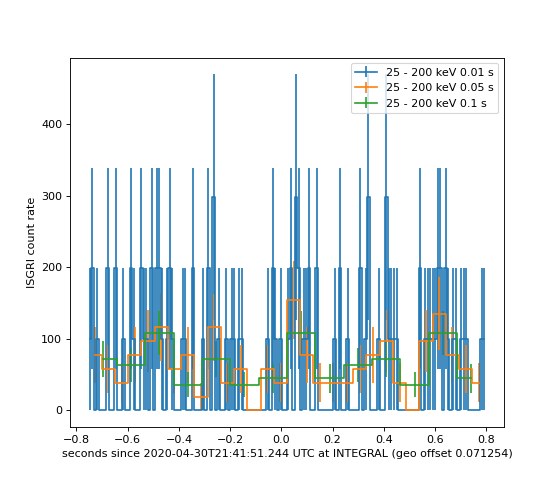

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 101
bins: [-0.75323266 -0.74316462 -0.73309658 -0.72302854 -0.7129605  -0.70289246
 -0.69282442 -0.68275638 -0.67268834 -0.66262031 -0.65255227 -0.64248423
 -0.63241619 -0.62234815 -0.61228011 -0.60221207 -0.59214403 -0.58207599
 -0.57200795 -0.56193992 -0.55187188 -0.54180384 -0.5317358  -0.52166776
 -0.51159972 -0.50153168 -0.49146364 -0.4813956  -0.47132756 -0.46125953
 -0.45119149 -0.44112345 -0.43105541 -0.42098737 -0.41091933 -0.40085129
 -0.39078325 -0.38071521 -0.37064717 -0.36057914 -0.3505111  -0.34044306
 -0.33037502 -0.32030698 -0.31023894 -0.3001709  -0.29010286 -0.28003482
 -0.26996678 -0.25989875 -0.24983071 -0.23976267 -0.22969463 -0.21962659
 -0.20955855 -0.19949051 -0.18942247 -0.17935443 -0.16928639 -0.15921836
 -0.14915032 -0.13908228 -0.12901424 -0.1189462  -0.10887816 -0.09881012
 -0.08874208 -0.07867404 -0.068606   -0.05853797 -0.04846993 -0.03840189
 -0.02833385 -0.01826581 -0.00819777  0.00187027  0.01193831  0.02200635
  0.03207439  0.04214

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


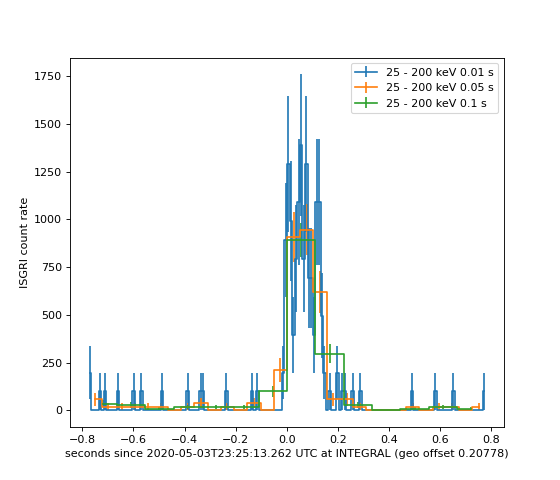

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 164
bins: [-7.75819083e-01 -7.65736776e-01 -7.55654469e-01 -7.45572162e-01
 -7.35489855e-01 -7.25407548e-01 -7.15325241e-01 -7.05242934e-01
 -6.95160627e-01 -6.85078320e-01 -6.74996013e-01 -6.64913706e-01
 -6.54831399e-01 -6.44749092e-01 -6.34666785e-01 -6.24584479e-01
 -6.14502172e-01 -6.04419865e-01 -5.94337558e-01 -5.84255251e-01
 -5.74172944e-01 -5.64090637e-01 -5.54008330e-01 -5.43926023e-01
 -5.33843716e-01 -5.23761409e-01 -5.13679102e-01 -5.03596795e-01
 -4.93514488e-01 -4.83432181e-01 -4.73349874e-01 -4.63267568e-01
 -4.53185261e-01 -4.43102954e-01 -4.33020647e-01 -4.22938340e-01
 -4.12856033e-01 -4.02773726e-01 -3.92691419e-01 -3.82609112e-01
 -3.72526805e-01 -3.62444498e-01 -3.52362191e-01 -3.42279884e-01
 -3.32197577e-01 -3.22115270e-01 -3.12032963e-01 -3.01950656e-01
 -2.91868350e-01 -2.81786043e-01 -2.71703736e-01 -2.61621429e-01
 -2.51539122e-01 -2.41456815e-01 -2.31374508e-01 -2.21292201e-01
 -2.11209894e-01 -2.01127587e-01 -1.91045280e-01 -1.80962973

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


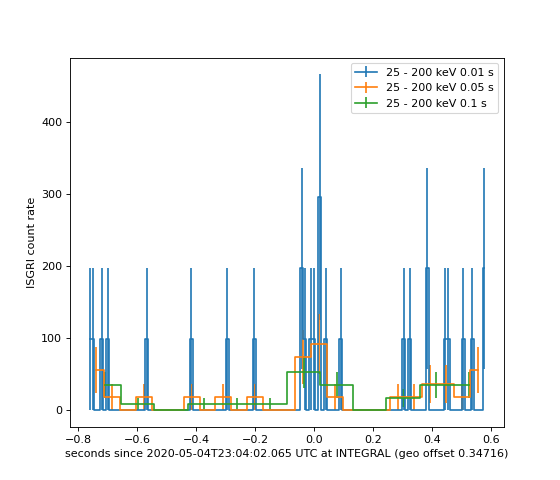

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 28
bins: [-0.76694752 -0.75679731 -0.74664711 -0.7364969  -0.72634669 -0.71619648
 -0.70604628 -0.69589607 -0.68574586 -0.67559566 -0.66544545 -0.65529524
 -0.64514504 -0.63499483 -0.62484462 -0.61469442 -0.60454421 -0.594394
 -0.5842438  -0.57409359 -0.56394338 -0.55379318 -0.54364297 -0.53349276
 -0.52334255 -0.51319235 -0.50304214 -0.49289193 -0.48274173 -0.47259152
 -0.46244131 -0.45229111 -0.4421409  -0.43199069 -0.42184049 -0.41169028
 -0.40154007 -0.39138987 -0.38123966 -0.37108945 -0.36093924 -0.35078904
 -0.34063883 -0.33048862 -0.32033842 -0.31018821 -0.300038   -0.2898878
 -0.27973759 -0.26958738 -0.25943718 -0.24928697 -0.23913676 -0.22898656
 -0.21883635 -0.20868614 -0.19853594 -0.18838573 -0.17823552 -0.16808531
 -0.15793511 -0.1477849  -0.13763469 -0.12748449 -0.11733428 -0.10718407
 -0.09703387 -0.08688366 -0.07673345 -0.06658325 -0.05643304 -0.04628283
 -0.03613263 -0.02598242 -0.01583221 -0.00568201  0.0044682   0.01461841
  0.02476862  0.03491882 

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


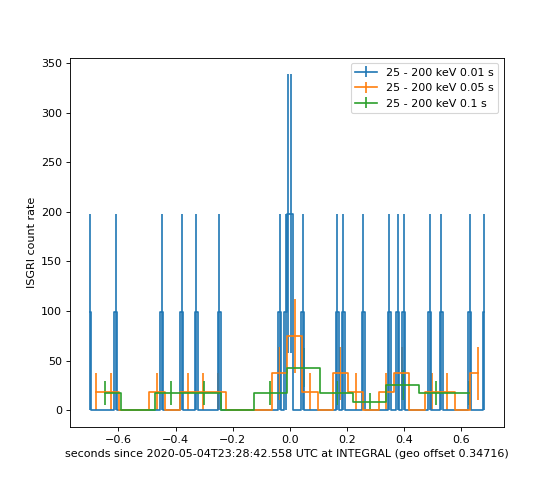

/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
/home/savchenk/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


events in selection 23
bins: [-7.05693121e-01 -6.95603302e-01 -6.85513483e-01 -6.75423664e-01
 -6.65333845e-01 -6.55244026e-01 -6.45154207e-01 -6.35064388e-01
 -6.24974569e-01 -6.14884750e-01 -6.04794931e-01 -5.94705112e-01
 -5.84615293e-01 -5.74525474e-01 -5.64435655e-01 -5.54345836e-01
 -5.44256017e-01 -5.34166198e-01 -5.24076379e-01 -5.13986560e-01
 -5.03896741e-01 -4.93806922e-01 -4.83717103e-01 -4.73627284e-01
 -4.63537465e-01 -4.53447646e-01 -4.43357827e-01 -4.33268008e-01
 -4.23178189e-01 -4.13088370e-01 -4.02998551e-01 -3.92908732e-01
 -3.82818913e-01 -3.72729094e-01 -3.62639275e-01 -3.52549456e-01
 -3.42459637e-01 -3.32369818e-01 -3.22279999e-01 -3.12190180e-01
 -3.02100361e-01 -2.92010541e-01 -2.81920722e-01 -2.71830903e-01
 -2.61741084e-01 -2.51651265e-01 -2.41561446e-01 -2.31471627e-01
 -2.21381808e-01 -2.11291989e-01 -2.01202170e-01 -1.91112351e-01
 -1.81022532e-01 -1.70932713e-01 -1.60842894e-01 -1.50753075e-01
 -1.40663256e-01 -1.30573437e-01 -1.20483618e-01 -1.10393799e

In [773]:
import re



def plot_period(t_refplot_utc):
    print(t_refplot_utc)
    sc = ic.get_sc(t_refplot_utc, ra=source_coord.ra.deg, dec=source_coord.dec.deg)
    dt_intgeo = sc['barytime']
    sc

    tc = ic.converttime("UTC", t_refplot_utc, "ANY")
    scwid = tc['SCWID']

    t_refplot_ijd = float(tc['IJD'])

    i_evts=fits.open("/mnt/sshfs/isdc-in01//unsaved_data/neronov/data/reduced/ddcache-private-staging-1.2//byscw/{}/{}.000/evts_extract.v0//06aef025/source_evts.fits.gz".format(scwid[:4], scwid))[2].data
    i_evts_en=i_evts

    ebands = [(25,200)]

    plt.figure(figsize=(7,6))

    rates={}

    bins = 0.05

    #tbin = 0.01
    
    burst_data={}

    for e1,e2 in ebands:
        m = i_evts_en['ENERGY']>=e1
        m &= i_evts_en['ENERGY']<e2

        #t_plot_geo_s = (i_evts['TIME'] + dt_intgeo/24/3600 -t_refplot_ijd)*24*3600
        t_plot_s = (i_evts['TIME'] -t_refplot_ijd)*24*3600

        m &= np.abs(t_plot_s)<0.8

        m &= i_evts['PIF_1']>0.3

        print("events in selection", sum(m))

        
        for tbin in 0.01, 0.05, 0.1:
            _ts = t_plot_s[m]
            bins=np.linspace(_ts.min(), _ts.max(), int((_ts.max()-_ts.min())/tbin))

            print("bins:", bins)

            h = np.histogram(t_plot_s[m], bins=bins)

            tc = (h[1][1:] + h[1][:-1])*0.5
            dt = (h[1][1:] - h[1][:-1])
            rate = h[0]/dt
            rate_err = h[0]**0.5/dt

            rates[(e1,e2)] = dict(
                rate = rate,
                rate_err = rate_err,
                tc = tc,
                dt = dt,
            )

            if True:
                plt.errorbar(
                    tc,
                    rate,
                    rate_err,
                    ds="steps-mid",
                    label="%.5lg - %.5lg keV %.5lg s"%(e1,e2,tbin),
                )
            else:
                plt.step(
                    tc,
                    rate,
                    ds="steps-mid",
                    label="%.5lg - %.5lg keV"%(e1,e2),
                    alpha=0.5,
                )


    #plt.xlim([-0, 0.6])
    #plt.xlim([.40, 0.55])
    plt.ylabel("ISGRI count rate")
    plt.xlabel("seconds since "+t_refplot_utc+" UTC at INTEGRAL (geo offset %.5lg)"%dt_intgeo)

    plt.legend()

    fn = "draft/PAPER_SGR1935_INTEGRAL/data/burst-search/burst-plots/lc_peakandspec_{}.pdf".format(re.sub("[:]", "-", t_refplot_utc))
    plt.savefig(fn)
    plt.savefig(fn.replace(".pdf", ".png"))
    
    

    plt.show()
    
    return burst_data, t_plot_s[m],  i_evts_en['ENERGY'][m]
    
    
    
#bd, t = plot_period("2020-05-03T23:25:13.262")

data_by_burst = {}

for burst in bursts:
    bd, t_rel_s, en = plot_period(burst['utc_integral'])
    data_by_burst[burst['utc_integral']] =  dict(t_rel_s=t_rel_s, en=en)



